# Clean`octopus`

In [5]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans
from tqdm.auto import tqdm
from plotnine import *
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import warnings
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_csv('data/octopus20200923.csv')

## Check for Dopplegangers

Many people with academic ranks have two `thai_db_name`s with different honorifics such as `ดร.` vs `สัตวแพทย์ ดร.` or no honorifics at all. We first check if they are treated as the same person in SCOPUS then deduplicate them.

In [16]:
dopple = df.groupby('scopus_name').field.count().reset_index().sort_values('field',ascending=False)
dopple = dopple[dopple.field>1]


def f(scopus_name):
    return df[df.scopus_name==scopus_name]

interact(f, scopus_name=list(dopple.scopus_name));

interactive(children=(Dropdown(description='scopus_name', options=('Sumrerng Jugjai', 'Vitit Muntarbhorn', 'So…

In [20]:
df[df.scopus_name.isin(list(dopple.scopus_name))].sort_values('scopus_name').head(10)

,Column1,academic_rank,thai_db_name,scopus_name,thai_affiliation,eng_affiliation,field,citation_count,doc_count,cited_by_count,h_index,co_author_count,highest_edu,employment_type
6997,6997,ศาสตราจารย์,อรัญ อินเจริญศักดิ์,Aran Incharoensakdi,จุฬาลงกรณ์มหาวิทยาลัย,Chulalongkorn University,ชีวเคมี,2108.0,145.0,1457.0,25.0,126.0,-,ข้าราชการ
3885,3885,ศาสตราจารย์,ดร. อรัญ อินจริญศักดิ์,Aran Incharoensakdi,จุฬาลงกรณ์มหาวิทยาลัย,Chulalongkorn University,ชีวเคมี,2108.0,145.0,1457.0,25.0,126.0,ปริญญาเอก,พนักงานมหาวิทยาลัย (สถาบันอุดมศึกษาของรัฐ)
294,294,ศาสตราจารย์,จุฬาภรณ์ พฤกษชาติคุณากร,Chulabhorn Pruksachatkun,มหาวิทยาลัยเชียงใหม่,Chiang Mai University,กุมารเวชศาสตร์,2.0,5.0,2.0,1.0,14.0,ปริญญาตรี,ข้าราชการ
7439,7439,ศาสตราจารย์,แพทย์หญิง จุฬาภรณ์ พฤกษชาติคุณ,Chulabhorn Pruksachatkun,มหาวิทยาลัยเชียงใหม่,Chiang Mai University,-,2.0,5.0,2.0,1.0,14.0,ปริญญาตรี,พนักงานมหาวิทยาลัย (สถาบันอุดมศึกษาของรัฐ)
295,295,ศาสตราจารย์,จุฬาภรณ์ รุ่งพิสุทธิพงษ์,Chulaporn Roongpisuthipong,มหาวิทยาลัยมหิดล,Mahidol University,-,290.0,22.0,282.0,9.0,50.0,ปริญญาตรี,พนักงานมหาวิทยาลัย (สถาบันอุดมศึกษาของรัฐ)
891,891,ศาสตราจารย์,ดร. จุฬาภรณ์ รุ่งพิสุทธิพงศ์,Chulaporn Roongpisuthipong,มหาวิทยาลัยมหิดล,Mahidol University,อายุรศาสตร์,290.0,22.0,282.0,9.0,50.0,ปริญญาเอก,ข้าราชการ
4100,4100,ศาสตราจารย์,ดร. เกศรา ณ บางช้าง,Kesara Na-Bangchang,มหาวิทยาลัยธรรมศาสตร์,Thammasart University,เภสัชวิทยาเขตร้อนคลินิก,4117.0,266.0,3070.0,34.0,503.0,ปริญญาเอก,ข้าราชการ
4099,4099,ศาสตราจารย์,ดร. เกศรา ณ,Kesara Na-Bangchang,มหาวิทยาลัยธรรมศาสตร์,Thammasart University,-,4117.0,266.0,3070.0,34.0,503.0,ปริญญาเอก,ข้าราชการ
4864,4864,ศาสตราจารย์,นายแพทย์ ขวัญชัย ศุภรัตน์ภิญโญ,Khuanchai Supparatpinyo,มหาวิทยาลัยเชียงใหม่,Chiang Mai University,-,4250.0,99.0,3080.0,34.0,672.0,ปริญญาตรี,ข้าราชการ
139,139,ศาสตราจารย์,ขวัญชัย ศุภรัตน์ภิญโญ,Khuanchai Supparatpinyo,มหาวิทยาลัยเชียงใหม่,Chiang Mai University,โรคติดเชื้อ,4250.0,99.0,3080.0,34.0,672.0,ปริญญาตรี,ข้าราชการ


In [8]:
scopus_df = df[~df.scopus_name.isna()]
nopus_df = df[df.scopus_name.isna()]
scopus_df['rnk'] = scopus_df.groupby('scopus_name').cumcount()+1
print(scopus_df.shape)
scopus_df = scopus_df[scopus_df.rnk==1].drop('rnk',1)
print(scopus_df.shape)
df = pd.concat([scopus_df,nopus_df]).reset_index(drop=True)
df = df.iloc[:,1:]
df.shape

(4514, 15)
(4494, 14)


(7575, 13)

## autoEDA

In [38]:
report = ProfileReport(df)
report

## Field Values to Field Groups

There are too many values in `fields`. In order to have a tractable number of fields for visualization, we perform the following procedures:

1. Use [multilingual universal sentence encoder (mUSE)](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3) to transform these text values into vectors of size 512
2. Perform k-means clustering to group them together; using silhouette score to determine k
3. Group the clusters together by hand; edit some fields which do not belong in the cluster

In [64]:
label_df = df.groupby('field').academic_rank.count().reset_index().sort_values('academic_rank',ascending=False).reset_index(drop=True).reset_index()
label_df

,index,field,academic_rank
0,0,-,871
1,1,เศรษฐศาสตร์,156
2,2,เภสัชศาสตร์,149
3,3,วิศวกรรมไฟฟ้า,140
4,4,อายุรศาสตร์,137
...,...,...,...
1097,1097,วิทยาศาสตร์การแพทย์,1
1098,1098,วิทยาศาสตร์การแพทย์พื้นฐาน,1
1099,1099,การบริหารการท่องเที่ยวและการโรงแรม,1
1100,1100,วิทยาศาสตร์ทางภาพถ่ายและเทคโนโลยีทางการพิมพ์,1


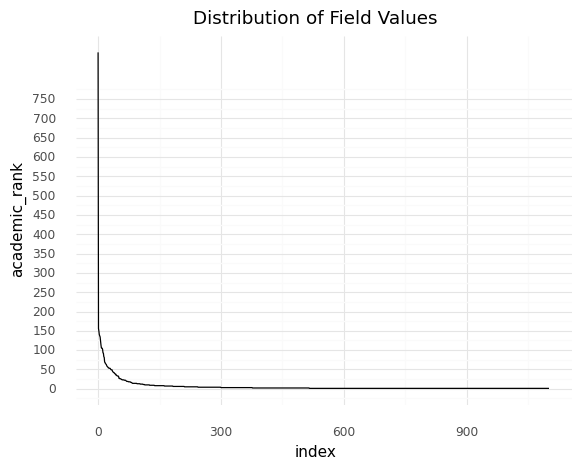

<ggplot: (-9223363264228614638)>

In [67]:
g = (ggplot(y, aes(x='index',y='academic_rank',group=1)) + geom_line() +
     theme_minimal()+ ggtitle('Distribution of Field Values') +
    scale_y_continuous(breaks=[i*50 for i in range(16)]))
g

In [70]:
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf #tensorflow 2.1.0

enc = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3')
fields = list(y.field[1:])
fields[:10]

['เศรษฐศาสตร์',
 'เภสัชศาสตร์',
 'วิศวกรรมไฟฟ้า',
 'อายุรศาสตร์',
 'เคมี',
 'คณิตศาสตร์',
 'วิศวกรรมเครื่องกล',
 'กุมารเวชศาสตร์',
 'วิศวกรรมโยธา',
 'พยาบาลศาสตร์']

In [71]:
field_embeddings = enc(fields).numpy()
field_embeddings.shape

(1101, 512)

In [59]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 100

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax+1)):
    kmeans = KMeans(n_clusters = k).fit(field_embeddings)
    labels = kmeans.labels_
    sil.append(silhouette_score(field_embeddings, labels, metric = 'euclidean'))

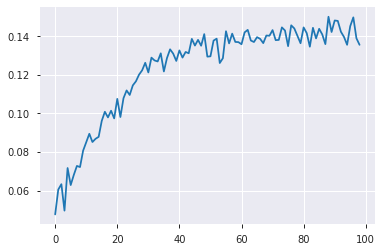

In [60]:
#see 60 as a reasonable k
plt.plot(sil)

In [146]:
k = 60
kmeans = KMeans(n_clusters = k,random_state=112).fit(field_embeddings)
labels = kmeans.labels_

In [164]:
results = pd.DataFrame({'field':fields,'cluster':labels})
results.groupby('cluster').field.agg([lambda x: ' '.join(x),len]).reset_index()

,cluster,<lambda_0>,len
0,0,เทคโนโลยีชีวภาพ เทคโนโลยีการศึกษา เทคโนโลยีทาง...,39
1,1,สูติศาสตร์-นรีเวชวิทยา สูติศาสตร์และนรีเวชวิทย...,14
2,2,กฎหมาย กฎหมายมหาชน กฎหมายระหว่างประเทศ กฎหมายอ...,18
3,3,จุลชีววิทยา จุลทรรศนศาสตร์คลินิก จุลชีววิทยาทา...,17
4,4,นิติศาสตร์ นิเทศศาสตร์ รัฐประศาสนศาสตร์ สถิติ ...,38
5,5,ครุศาสตร์เครื่องกล วิศวกรรมแหล่งน้ำ วิศวกรรมพอ...,16
6,6,ชีววิทยา ชีววิทยาช่องปาก ชีววิทยาประมง อณูพันธ...,28
7,7,การจัดการสิ่งแวดล้อม ทรัพยากรที่ดินและสิ่งแวดล...,8
8,8,เทคโนโลยีการเกษตร เกษตรศาสตร์ ส่งเสริมการเกษตร...,23
9,9,หลักสูตรและการสอน การสอนภาษาอังกฤษ หลักสูตรการ...,13


In [170]:
df_cluster = df.merge(results,how='left',on='field')
df_cluster['cluster'] = df_cluster.cluster.fillna(-1)
df_cluster = df_cluster.groupby(['cluster','field']).academic_rank.count().reset_index()
# df_cluster.to_csv('data/field_group.csv',index=False)

### Handcrafted groups: clusters
We create handcrafted groups based on the clusters. The guideline of grouping is roughly based on Chulalongkorn University's categorization. Groups that do not make sense are classified as `others`. Note that this is a highly subjective process and there might be debates on how and why fields are put into a particular field group such as why education is in `liberal_arts` whereas sociology is in `social_science`, or why architecture is in `engineering`.

1. `engineering`
2. `liberal_arts`:
3. `medicine`
4. `natural_science`
5. `social_science`
6. `unknown`

In [9]:
labs_df = pd.read_csv('data/field_group_hand.csv')
labs_df.groupby('field_group').field.count()

field_group
engineering        140
liberal_arts       210
medicine           250
natural_science    302
social_science     198
unknown              2
Name: field, dtype: int64

In [10]:
df = df.merge(labs_df[['field','field_group']],how='left',on='field')
df.groupby('field_group').academic_rank.count()

field_group
engineering         960
liberal_arts        985
medicine           1777
natural_science    1979
social_science      994
unknown             880
Name: academic_rank, dtype: int64

## Employment Group to Funded by Whom

In [11]:
employment_d = {
    'พนักงานมหาวิทยาลัย (สถาบันอุดมศึกษาของรัฐ)': 'gov_university',
    'อาจารย์วิทยาลัยเอกชน': 'private_university', 
    'ลูกจ้างชั่วคราว (สถาบันอุดมศึกษาของรัฐ)': 'gov_university',
    'อาจารย์มหาวิทยาลัยเอกชน':'private_university', 
    'ข้าราชการ':'government', 
    'ต่ออายุราชการ':'government',
    'พนักงานราชการ (สถาบันอุดมศึกษาของรัฐ)':'government', 
    'อื่นๆ':'unknown',
    'ลูกจ้างประจำ (สถาบันอุดมศึกษาของรัฐ)':'gov_university',
    'ผู้ปฏิบัติงาน (สถาบันอุดมศึกษาของรัฐ)': 'gov_university'
}

df['funded_by'] = df.employment_type.map(lambda x: employment_d[x])
df.groupby('funded_by').academic_rank.count()

funded_by
gov_university        1964
government            5093
private_university     499
unknown                 19
Name: academic_rank, dtype: int64

In [13]:
# df.to_csv('data/octopus_field_group.csv',index=False)